In [1]:
PATH = "../../"

import os
for dirname, _, filenames in os.walk(PATH + "Dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../Dataset\rev01\10\10_20201022 (16030).JPG
../../Dataset\rev01\11\11_20201029 (15).JPG
../../Dataset\rev01\11\11_20201029 (17).JPG
../../Dataset\rev01\11\11_20201029 (18).JPG
../../Dataset\rev01\11\11_20201029 (19).JPG
../../Dataset\rev01\11\11_20201029 (20).JPG
../../Dataset\rev01\11\11_20201101 (134).JPG
../../Dataset\rev01\11\11_20201101 (137).JPG
../../Dataset\rev01\11\11_20201101 (139).JPG
../../Dataset\rev01\11\11_20201101 (141).JPG
../../Dataset\rev01\11\11_20201101 (142).JPG
../../Dataset\rev01\11\11_20201101 (143).JPG
../../Dataset\rev01\11\11_20201101 (93).JPG
../../Dataset\rev01\11\11_20201110 (157).JPG
../../Dataset\rev01\11\11_20201110 (158).JPG
../../Dataset\rev01\11\11_20201110 (161).JPG
../../Dataset\rev01\11\11_20201110 (162).JPG
../../Dataset\rev01\11\11_20201116 (221).JPG
../../Dataset\rev01\12\12_20201027 (44).JPG
../../Dataset\rev01\12\12_20201028 (59).JPG
../../Dataset\rev01\12\12_20201028 (64).JPG
../../Dataset\rev01\12\12_20201106 (156).JPG
../../Dataset\rev

# Problem Statement

<li>VegCart(Random Name) is a fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.</li>

<li>As a starting point, we have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.</li>

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

In [3]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(PATH + "Models/final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [6]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Ruta del archivo CSV que contiene las etiquetas y rutas de las imágenes
csv_file = PATH + "CSVs/dataset/train.csv"
PATH_IMAGENES = PATH + "Dataset/"

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(csv_file)

image_dict = {} # dict to store image array (key) for every class (value)
count_dict = {} # dict to store count of files (key) for every class (value)

# Obtener las clases únicas del DataFrame
classes = df['class'].unique()

# Iterar sobre las clases únicas
for cls in classes:
    # Filtrar el DataFrame por clase
    class_df = df[df['class'] == cls]

    # Obtener una imagen aleatoria de la clase
    random_index = random.choice(class_df.index)
    image_path = os.path.join(PATH_IMAGENES, class_df.loc[random_index, 'path'])

    # Cargar la imagen usando la función de utilidad de keras y guardarla en image_dict
    img = tf.keras.utils.load_img(image_path)
    image_dict[cls] = img

    # Contar el número de imágenes en la clase y guardar el recuento en count_dict
    count_dict[cls] = len(class_df)

Ya


# Exploratory Data Analysis

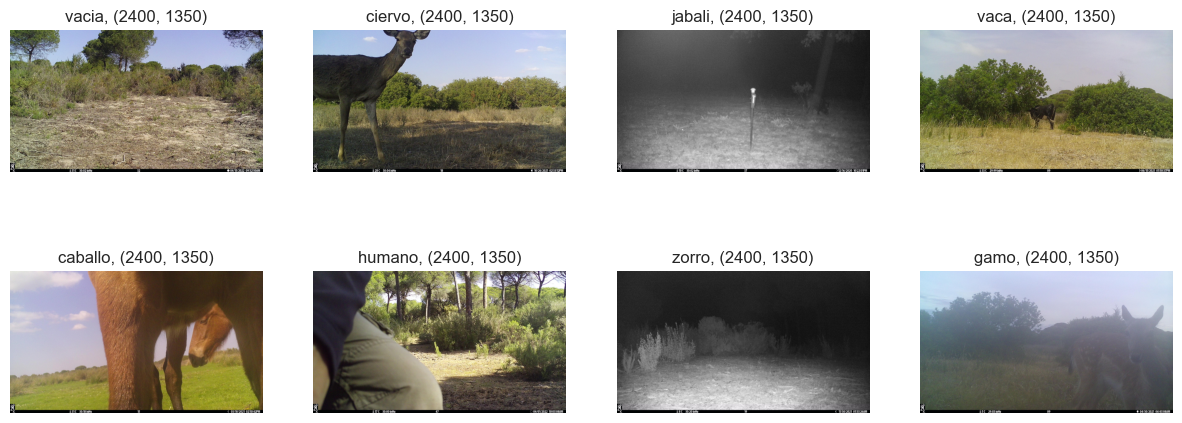

In [16]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [17]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
      class  count
0    vacia    793
1   ciervo    800
2   jabali    800
3     vaca    800
4  caballo    800
5   humano    799
6    zorro    799
7     gamo    800


<Figure size 1500x1200 with 0 Axes>

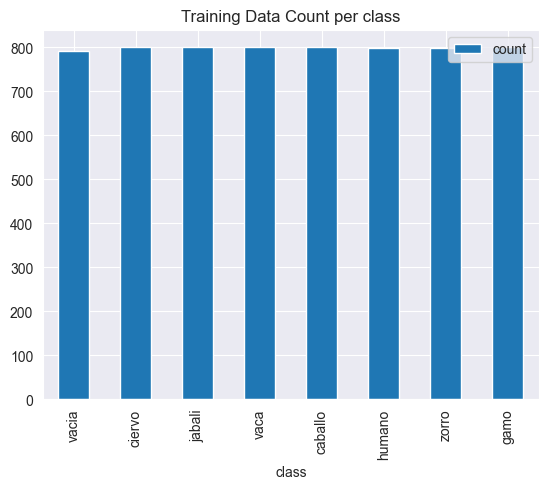

In [18]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()

# Loading data set

In [31]:
import shutil

# Rutas de los archivos CSV que contienen las etiquetas y rutas de las imágenes
train_csv_file = PATH + "CSVs/dataset/train.csv"
val_csv_file = PATH + "CSVs/dataset/val.csv"
test_csv_file = PATH + "CSVs/dataset/test.csv"

# Directorio de las imágenes originales
imgs_path = PATH + "Dataset/"

# Directorio donde se almacenarán las imágenes divididas
split_path = PATH + "SplitDataset/"
train_dir = split_path + "train/"
val_dir = split_path + "val/"
test_dir = split_path + "test/"

'''# Crear el directorio de SplitDataset si no existe
if not os.path.exists(split_path):
    os.makedirs(split_path)

# Función auxiliar para copiar las imágenes a las carpetas correspondientes
def copy_images_to_folders(csv_file, dest_dir):
    # Cargar el archivo CSV en un DataFrame de pandas
    df = pd.read_csv(csv_file)

    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        image_path = row['path']
        image_class = row['class']

        # Directorio de destino para la imagen según su clase
        class_dir = os.path.join(dest_dir, image_class)

        # Crear la carpeta de la clase si no existe
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Ruta completa de la imagen de origen y destino
        src_image = os.path.join(imgs_path, image_path)
        dest_image = os.path.join(class_dir, os.path.basename(image_path))

        # Copiar la imagen a la carpeta correspondiente
        shutil.copyfile(src_image, dest_image)

# Copiar las imágenes a las carpetas de train, val y test
copy_images_to_folders(train_csv_file, train_dir)
copy_images_to_folders(val_csv_file, val_dir)
copy_images_to_folders(test_csv_file, test_dir)'''

In [32]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir, shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir, shuffle = False,
)


Loading Train Data...
Found 6391 files belonging to 8 classes.

Loading Validation Data...
Found 800 files belonging to 8 classes.

Loading Test Data...
Found 799 files belonging to 8 classes.


# Data Preprocessing

In [33]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [40]:
num_classes = 8
hidden_size_1 = 1024
hidden_size_2 = 256


# Training Simple Neural Network (MLP)

Running a ANN for the given images


In [41]:
model_ann = keras.Sequential(
    name="model_ann",
    layers=[
        layers.Flatten(input_shape=(height, width, 3)),
        layers.Dense(units=hidden_size_1, activation='relu'), # hidden layer 1
        layers.Dense(units=hidden_size_2, activation='relu'), # hidden layer 2
        layers.Dense(units=num_classes, activation='softmax'), # output layer
    ]
)

In [42]:
model_ann.summary()

Model: "model_ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 1024)              154141696 
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 154,406,152
Trainable params: 154,406,152
Non-trainable params: 0
_________________________________________________________________


In [43]:
tf.keras.utils.plot_model(model_ann, to_file="model_ann.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
epochs = 25
model_fit = model_ann.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
200/200 [==============================] - 126s 617ms/step - loss: 22.0673 - accuracy: 0.2449 - val_loss: 4.5429 - val_accuracy: 0.1650
Epoch 2/25
200/200 [==============================] - 118s 584ms/step - loss: 2.7793 - accuracy: 0.3812 - val_loss: 3.9581 - val_accuracy: 0.2075
Epoch 3/25
200/200 [==============================] - 109s 540ms/step - loss: 1.8926 - accuracy: 0.4298 - val_loss: 2.9249 - val_accuracy: 0.2163
Epoch 4/25
200/200 [==============================] - 109s 537ms/step - loss: 1.6024 - accuracy: 0.4606 - val_loss: 3.0241 - val_accuracy: 0.2025
Epoch 5/25
200/200 [==============================] - 117s 579ms/step - loss: 1.4190 - accuracy: 0.5076 - val_loss: 2.7140 - val_accuracy: 0.2163
Epoch 6/25
200/200 [==============================] - 113s 557ms/step - loss: 1.3328 - accuracy: 0.5343 - val_loss: 2.8633 - val_accuracy: 0.2075
Epoch 7/25
200/200 [==============================] - 114s 563ms/step - loss: 1.4132 - accuracy: 0.5170 - val_loss: 2.7921 

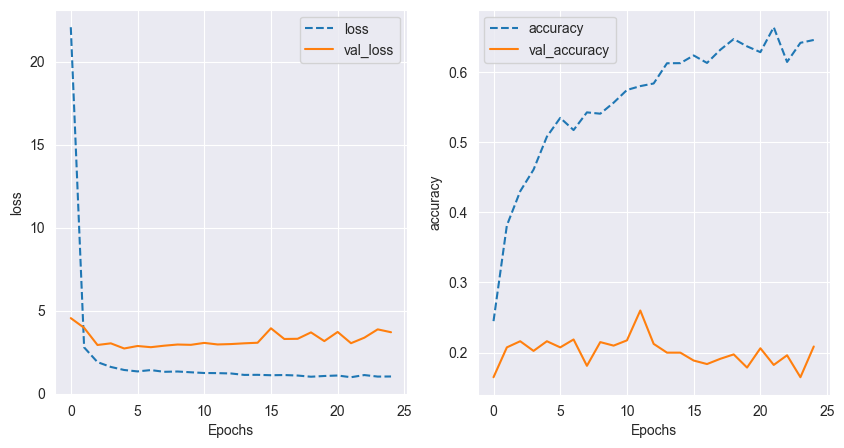

In [46]:
training_plot(['loss', 'accuracy'], model_fit)

In [47]:
testAccuracy(model_ann)

25/25 [==============================] - 5s 141ms/step

Test Accuracy: 33.04%



25/25 [==============================] - 5s 151ms/step


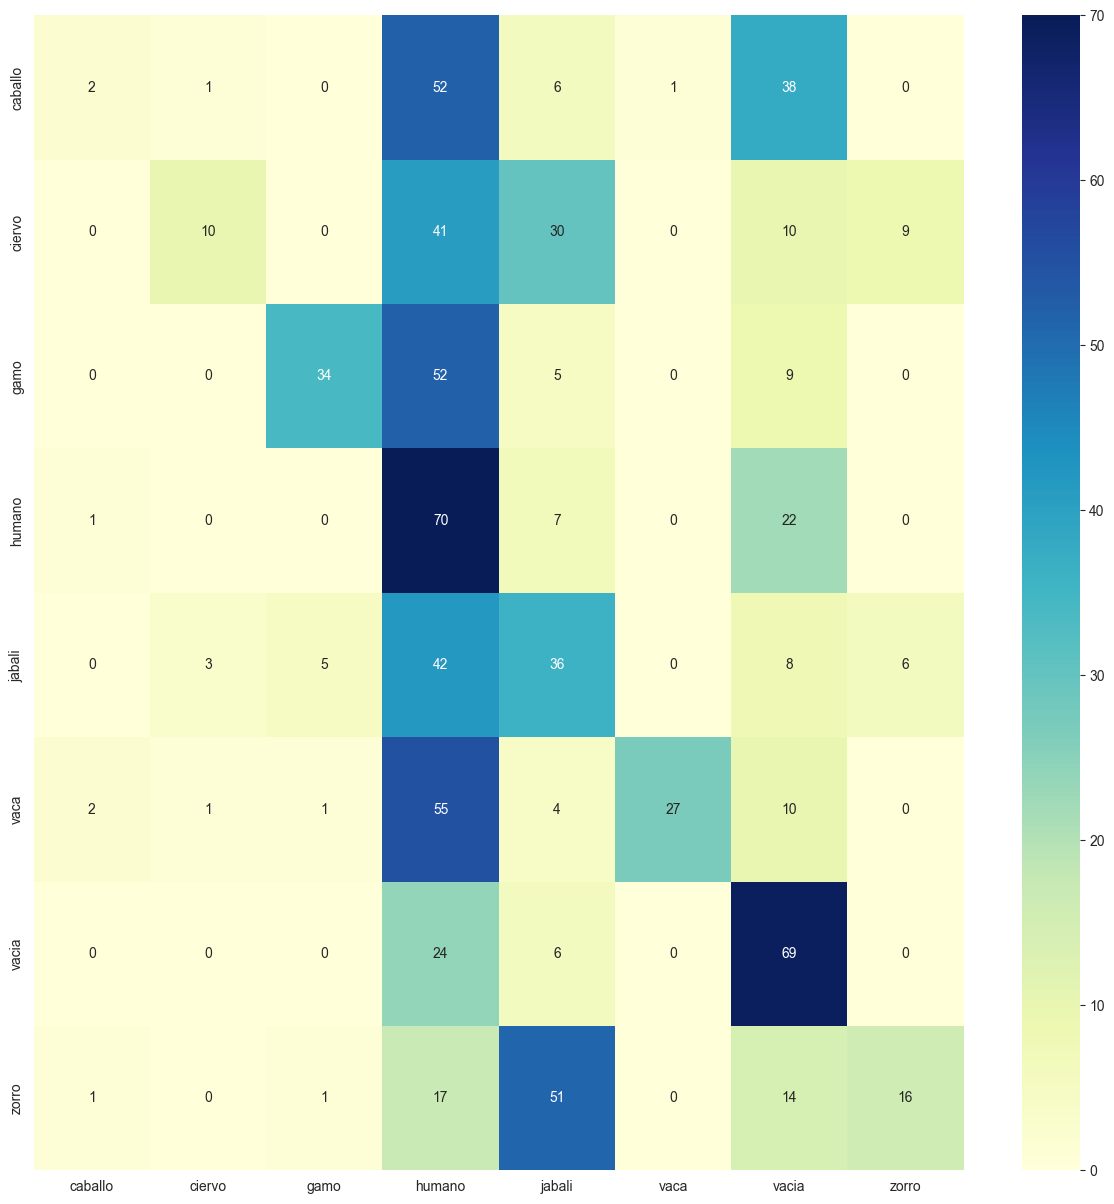

In [48]:
ConfusionMatrix(model_ann, test_ds, test_data.class_names)

# Transfer Learning

# MobileNet

In [52]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [53]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [55]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
200/200 [==============================] - 106s 507ms/step - loss: 1.2265 - accuracy: 0.5683 - val_loss: 1.2896 - val_accuracy: 0.5263
Epoch 2/10
200/200 [==============================] - 105s 517ms/step - loss: 0.8614 - accuracy: 0.7126 - val_loss: 1.2160 - val_accuracy: 0.5512
Epoch 3/10
200/200 [==============================] - 112s 554ms/step - loss: 0.7638 - accuracy: 0.7431 - val_loss: 1.2257 - val_accuracy: 0.5625
Epoch 4/10
200/200 [==============================] - 115s 566ms/step - loss: 0.6903 - accuracy: 0.7726 - val_loss: 1.2353 - val_accuracy: 0.5713
Epoch 5/10
200/200 [==============================] - 112s 557ms/step - loss: 0.6550 - accuracy: 0.7853 - val_loss: 1.2278 - val_accuracy: 0.5713
Epoch 6/10
200/200 [==============================] - 106s 526ms/step - loss: 0.6063 - accuracy: 0.8008 - val_loss: 1.2362 - val_accuracy: 0.5550
Epoch 7/10
200/200 [==============================] - 107s 530ms/step - loss: 0.5854 - accuracy: 0.8058 - val_loss: 1.2896 -

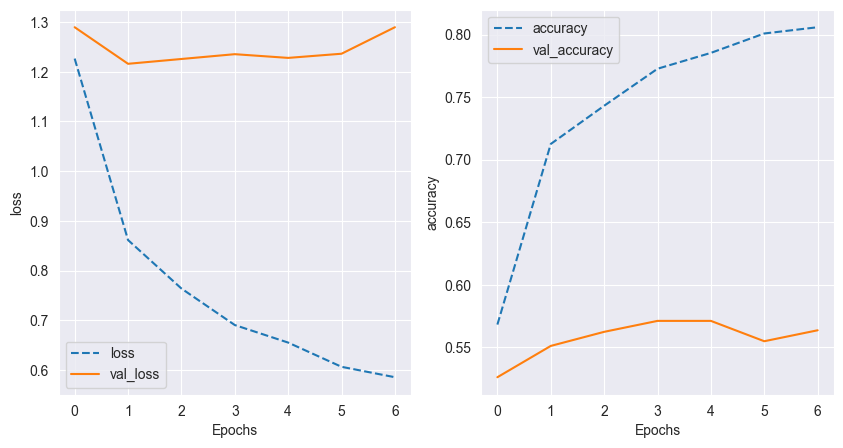

In [56]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [57]:
testAccuracy(mobilenet_model)

25/25 [==============================] - 13s 429ms/step

Test Accuracy: 67.08%



25/25 [==============================] - 12s 420ms/step


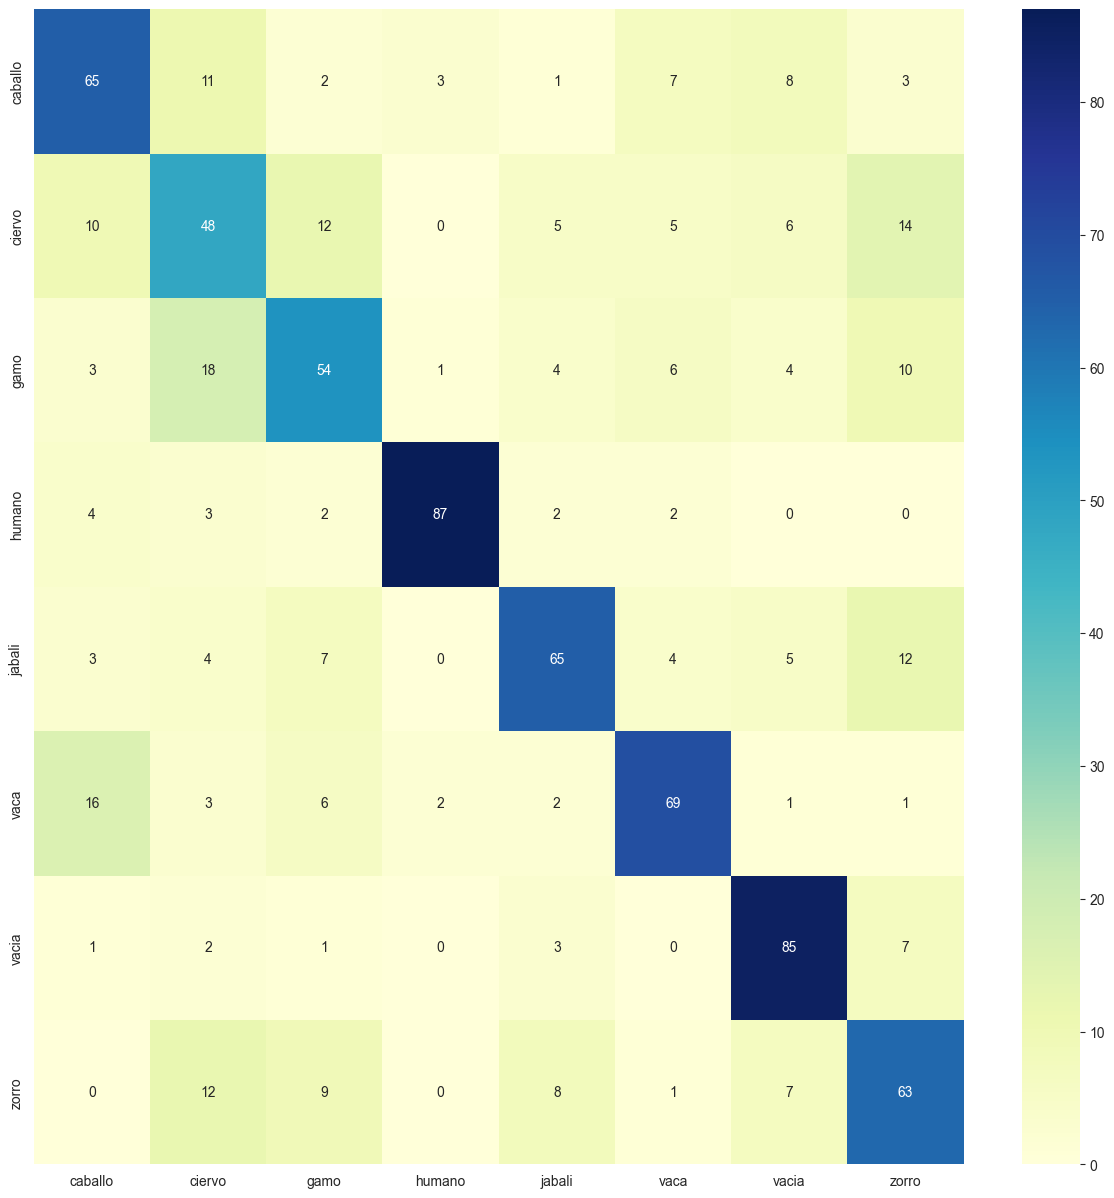

In [58]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

# Checking Predictions with the best models -
- ResNet
- MobileNet

25/25 [==============================] - 11s 423ms/step


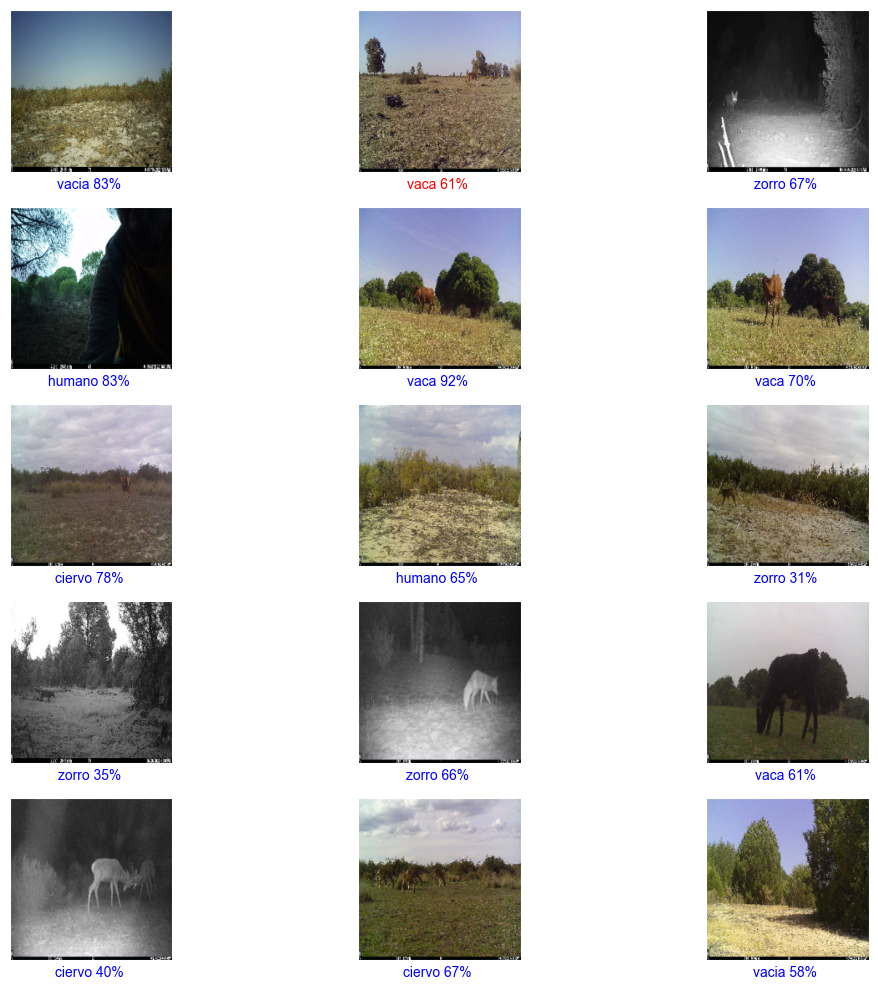

In [60]:
predictions(mobilenet_model)

25/25 [==============================] - 12s 459ms/step


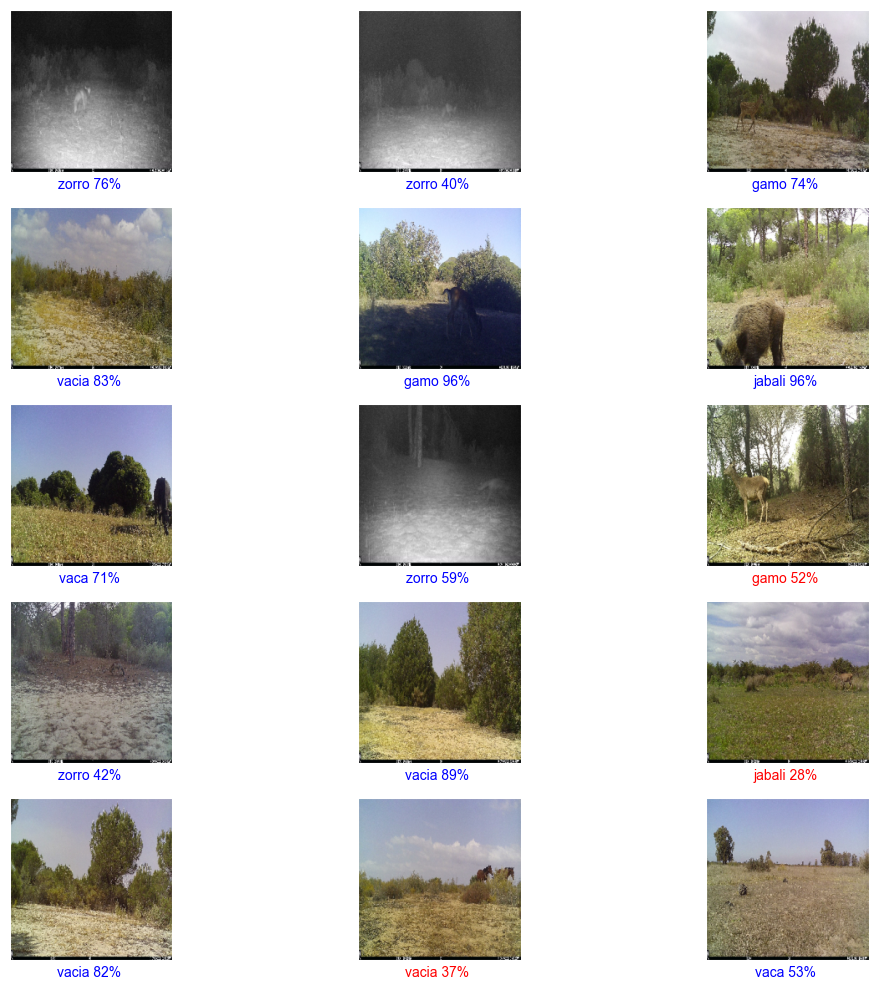

In [61]:
predictions(mobilenet_model)

# Summary
<ul>
  <li>Simple MLP: Being a simple ANN the model is misclassifying the 'Cucumber','Papaya' and 'Cauliflower' and gives a test accuracy of around 75%.</li>
  <li>Baseline Model: The model itself is performing really well with the data set and giving 74% test accuracy.</li>
  <li>Improved Baseline Model: By adding more depth to the model and adding Batchnormalization and Dropout layers with early stopping the model exceptionally well with test accuracy above 90%. </li>
  <li>Transfer Learning: All the models performed really well and test accuracy was exceptionally amazing with simple architecture like Mobilenet and surprisingly well with the naive model like VGG16.</li>
</ul>
